# **Campaign Response**

Ampika Thanakaew ID: 6210422049

## **Initialize**

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 129kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [55]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [70]:
%cd '/content/drive/MyDrive/BADS 7105 CRM/Campaign Response/'
%ls

/content/drive/MyDrive/BADS 7105 CRM/Campaign Response
Retail_Data_Response.csv  Retail_Data_Transactions.csv


**Load Data**

In [71]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [72]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [59]:
# Cleansing for 5 customers without response data
set(df_transactions.customer_id).difference(df_response.customer_id)

df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


 **EDA**

In [60]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [50]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

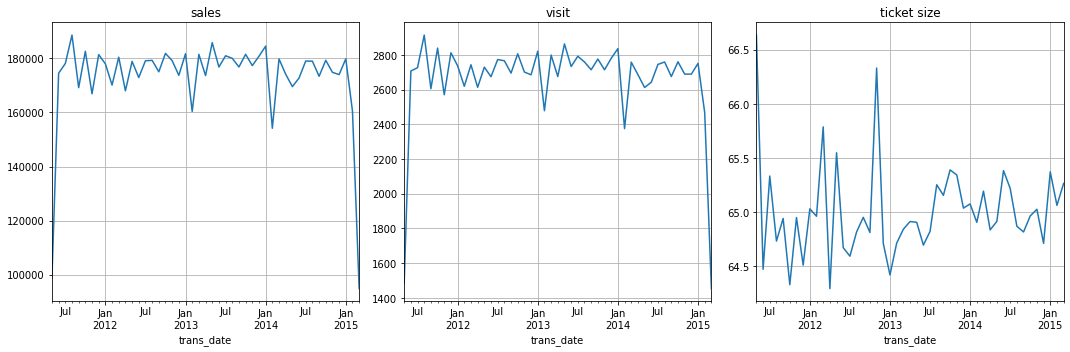

In [61]:
fig, axes = plt.subplots(1,3, figsize=(15,5), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='visit', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].apply(lambda x: x.sum()/x.count()).plot(title='ticket size')
for ax in axes:
    ax.grid(True)

plt.show()

 **Data Preparation**

In [69]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])
basket_cuts = [0,35,80,float('inf')]
df_transactions['basket_size'] = pd.cut(df_transactions['tran_amount'], basket_cuts, right=False, labels=['S','M','L'])
# df_transactions['recent']= campaign_date - df_transactions['trans_date']
# df_transactions['recent'].astype('timedelta64[D]')
# df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,age,is_weekend,basket_size,recent
0,CS5295,2013-02-11,35,764,False,M,764.0
1,CS4768,2015-03-15,39,2,True,M,2.0
2,CS2122,2013-02-26,52,749,False,M,749.0
3,CS1217,2011-11-16,99,1217,False,L,1217.0
4,CS1850,2013-11-20,78,482,False,M,482.0


In [66]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),    # Recency
                                                     'customer_id': lambda x: len(x),                     # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [73]:
## Calculate response rate

response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


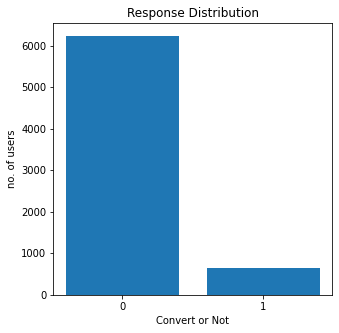

In [74]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

In [75]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


**Train and Test Dataset**

In [78]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 3)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 3)
Number transactions y_test dataset:  (2066,)


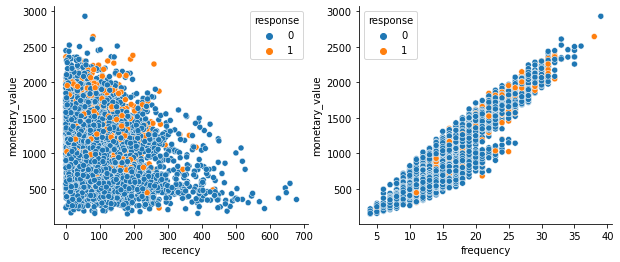

In [107]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response', ax=axes[0])
sns.scatterplot(data=df_modeling, x='frequency', y='monetary_value', hue='response', ax=axes[1])
sns.despine()
# plt.title("Imbalanced Data")
plt.show()

**Fixing Imbalanced with Undersampling**

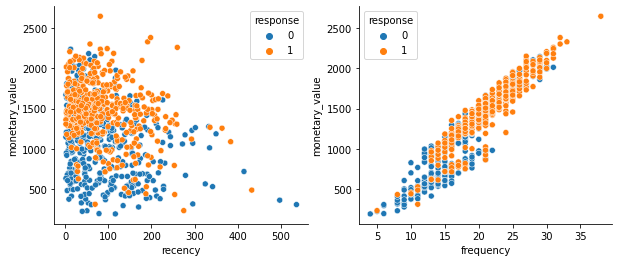

In [108]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response', ax=axes[0])
sns.scatterplot(data=df_undersampled, x='frequency', y='monetary_value', hue='response', ax=axes[1])

sns.despine()
# plt.title("Undersampled Data")
plt.show()

**Fixing Imbalanced with Oversampling**

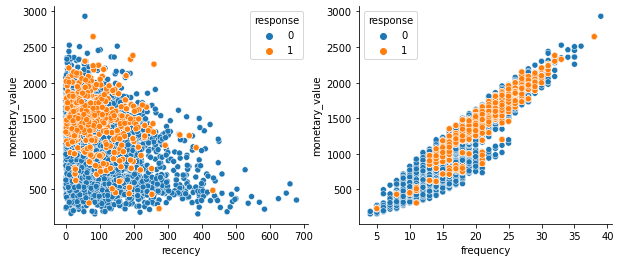

In [109]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response', ax=axes[0])
sns.scatterplot(data=df_oversampled, x='frequency', y='monetary_value', hue='response', ax=axes[1])

sns.despine()
# plt.title("Oversampled Data")
plt.show()

**Fixing Imbalanced with SMOTE**

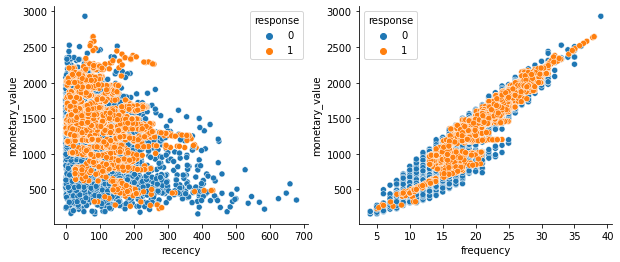

In [110]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'response']

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response', ax=axes[0])
sns.scatterplot(data=df_SMOTE, x='frequency', y='monetary_value', hue='response', ax=axes[1])
sns.despine()
# plt.title("SMOTE Data")
plt.show()

**Logistic Regression**

In [83]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       429
           1       0.65      0.72      0.69       429

    accuracy                           0.67       858
   macro avg       0.67      0.67      0.67       858
weighted avg       0.67      0.67      0.67       858

test set
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      1848
           1       0.18      0.76      0.30       218

    accuracy                           0.62      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.62      0.69      2066



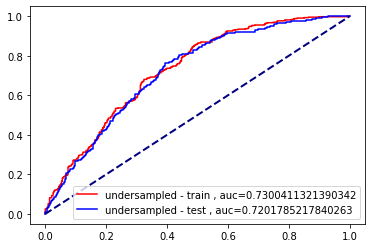

In [84]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [85]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00368411 -0.03621944  0.00246363]] [-2.80649227]


In [86]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.67      0.62      0.65      4389
           1       0.65      0.69      0.67      4389

    accuracy                           0.66      8778
   macro avg       0.66      0.66      0.66      8778
weighted avg       0.66      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1848
           1       0.19      0.72      0.30       218

    accuracy                           0.64      2066
   macro avg       0.57      0.68      0.53      2066
weighted avg       0.87      0.64      0.71      2066



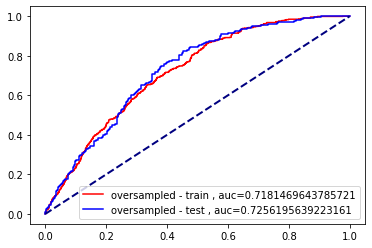

In [87]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [88]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[0.00415889 0.02516016 0.00181298]] [-2.80649227]


In [89]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



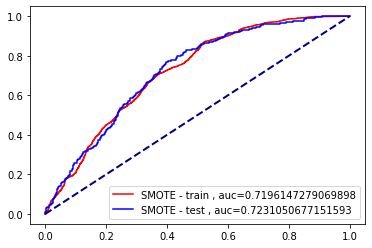

In [90]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [91]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[0.00371859 0.00684075 0.00207781]] [-2.80649227]


**XGBoost**

In [92]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.705229
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713788
[2]	validation_0-auc:0.716027
[3]	validation_0-auc:0.716674
[4]	validation_0-auc:0.715722
[5]	validation_0-auc:0.716981
[6]	validation_0-auc:0.715989
[7]	validation_0-auc:0.717465
[8]	validation_0-auc:0.716698
[9]	validation_0-auc:0.718954
[10]	validation_0-auc:0.718443
[11]	validation_0-auc:0.720803
[12]	validation_0-auc:0.721902
[13]	validation_0-auc:0.721018
[14]	validation_0-auc:0.722452
[15]	validation_0-auc:0.723688
[16]	validation_0-auc:0.723585
[17]	validation_0-auc:0.726791
[18]	validation_0-auc:0.727038
[19]	validation_0-auc:0.727042
[20]	validation_0-auc:0.727542
[21]	validation_0-auc:0.727999
[22]	validation_0-auc:0.728137
[23]	validation_0-auc:0.729541
[24]	validation_0-auc:0.729021
[25]	validation_0-auc:0.728669
[26]	validation_0-auc:0.728642
[27]	validation_0-auc:0.73034
[28]	validation_0-auc:0.730049
[29]	validation_0-au

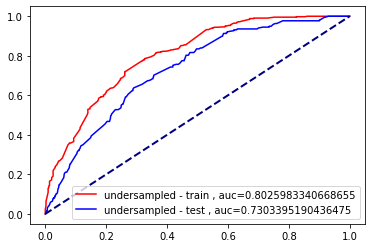

In [93]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

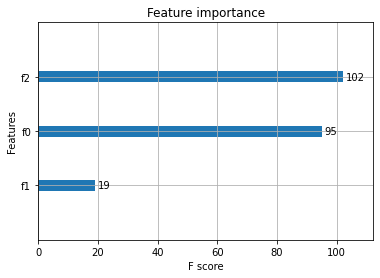

In [94]:
xgb.plot_importance(xgb_model_under)

In [95]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.71776
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.730129
[2]	validation_0-auc:0.731335
[3]	validation_0-auc:0.732199
[4]	validation_0-auc:0.732009
[5]	validation_0-auc:0.733986
[6]	validation_0-auc:0.734008
[7]	validation_0-auc:0.734353
[8]	validation_0-auc:0.734721
[9]	validation_0-auc:0.734507
[10]	validation_0-auc:0.737226
[11]	validation_0-auc:0.737584
[12]	validation_0-auc:0.737529
[13]	validation_0-auc:0.738018
[14]	validation_0-auc:0.738306
[15]	validation_0-auc:0.738075
[16]	validation_0-auc:0.73867
[17]	validation_0-auc:0.738399
[18]	validation_0-auc:0.738837
[19]	validation_0-auc:0.738752
[20]	validation_0-auc:0.738777
[21]	validation_0-auc:0.73744
[22]	validation_0-auc:0.738809
[23]	validation_0-auc:0.738641
Stopping. Best iteration:
[18]	validation_0-auc:0.738837

training set
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      438

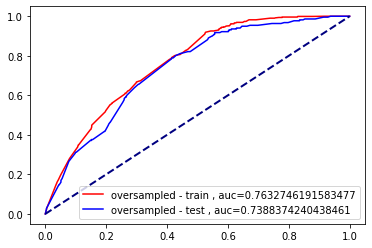

In [96]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

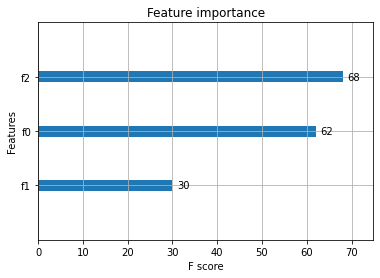

In [97]:
xgb.plot_importance(xgb_model_over)

In [98]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.719724
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.723431
[2]	validation_0-auc:0.735221
[3]	validation_0-auc:0.734822
[4]	validation_0-auc:0.733489
[5]	validation_0-auc:0.734515
[6]	validation_0-auc:0.73512
[7]	validation_0-auc:0.739788
[8]	validation_0-auc:0.737715
[9]	validation_0-auc:0.743504
[10]	validation_0-auc:0.743524
[11]	validation_0-auc:0.739335
[12]	validation_0-auc:0.740311
[13]	validation_0-auc:0.738329
[14]	validation_0-auc:0.7399
[15]	validation_0-auc:0.739269
Stopping. Best iteration:
[10]	validation_0-auc:0.743524

training set
              precision    recall  f1-score   support

           0       0.81      0.59      0.69      4389
           1       0.68      0.86      0.76      4389

    accuracy                           0.73      8778
   macro avg       0.75      0.73      0.72      8778
weighted avg       0.75      0.73      0.72      8778

test set
              precision  

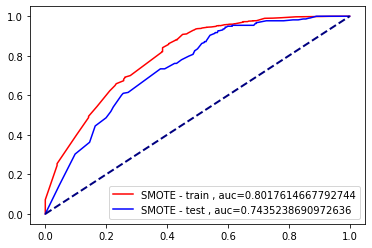

In [99]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

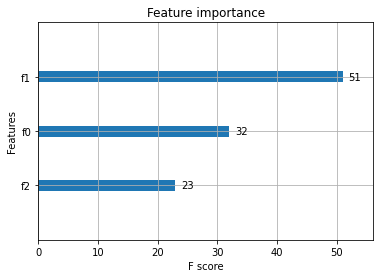

In [100]:
xgb.plot_importance(xgb_model_SMOTE)

In [101]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.611373
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.733395
[2]	validation_0-auc:0.728699
[3]	validation_0-auc:0.738274
[4]	validation_0-auc:0.738525
[5]	validation_0-auc:0.732941
[6]	validation_0-auc:0.740621
[7]	validation_0-auc:0.741142
[8]	validation_0-auc:0.740015
[9]	validation_0-auc:0.739549
[10]	validation_0-auc:0.741946
[11]	validation_0-auc:0.737816
[12]	validation_0-auc:0.738247
[13]	validation_0-auc:0.737253
[14]	validation_0-auc:0.736756
[15]	validation_0-auc:0.736153
Stopping. Best iteration:
[10]	validation_0-auc:0.741946

training set
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      4389
           1       0.70      0.86      0.77      4389

    accuracy                           0.74      8778
   macro avg       0.76      0.74      0.74      8778
weighted avg       0.76      0.74      0.74      8778

test set
   